In [109]:
import pandas as pd


df_train = pd.read_parquet('train.parquet')
df_val = pd.read_parquet('val.parquet')
df_test = pd.read_parquet('test.parquet')

In [110]:
df_train.dropna()


,Unnamed: 0,title,text,subject,date,label
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0
...,...,...,...,...,...,...
29995,6880,U.S. aerospace industry urges Trump to help Ex...,The chief executive of the U.S. Aerospace Indu...,politicsNews,"December 6, 2016",1
29996,17818,Highlights: Hong Kong leader Carrie Lam delive...,The following are highlights of the maiden pol...,worldnews,"October 11, 2017",1
29997,5689,Obama Literally LAUGHS At Claims That Brexit M...,If there s one thing President Barack Obama is...,News,"June 28, 2016",0
29998,15805,Syrian army takes full control of Deir al-Zor ...,The Syrian army and its allies have taken full...,worldnews,"November 2, 2017",1


In [111]:


conflicts = df_train.groupby('title')['label'].nunique()
conflicted_titles = conflicts[conflicts > 1]

print(f"{len(conflicted_titles)} conflicting titles found.")
print(conflicted_titles.head())

0 conflicting titles found.
Series([], Name: label, dtype: int64)


In [112]:
df_train.drop_duplicates(subset='title', inplace=True)

df_val.drop_duplicates(subset='title', inplace=True)

df_val.shape


(5893, 6)

In [113]:
df_val.head()

,Unnamed: 0,title,text,subject,date,label
0,14074,TRUMP HATER GEORGE RAMOS Promotes Movie Showin...,Mexico has been the beneficiary of our open bo...,politics,"Apr 20, 2016",0
1,17592,Germany seeks to maintain unity if U.S. decert...,The German government on Friday vowed to work ...,worldnews,"October 13, 2017",1
2,5694,No sign U.S. wants to cancel nuclear deal with...,German Foreign Minister Sigmar Gabriel said it...,politicsNews,"February 2, 2017",1
3,20036,Brazil prosecutors seek to extend Batista dete...,The Office of Brazil s Prosecutor-General Rodr...,worldnews,"September 14, 2017",1
4,234,Trump Just Asked The Most Unqualified Person E...,"Trump, who keeps promising to either scrap our...",News,"October 10, 2017",0


In [114]:
df_test.head()

,Unnamed: 0,title,text,subject,date,label
0,8104,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,News,"February 14, 2016",0
1,7467,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,politicsNews,"November 9, 2016",1
2,9473,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,politics,"Nov 9, 2017",0
3,276,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,politicsNews,"December 7, 2017",1
4,19274,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,left-news,"Jan 21, 2017",0


In [115]:
X = df_train.drop("label", axis = 1)
X_t = X.drop("Unnamed: 0", axis = 1)
V = df_val.drop("label", axis = 1)
V_t = V.drop("Unnamed: 0", axis = 1)

X_t.head()
X_t.shape


(27149, 4)

In [116]:
y_t = df_train['label']
v_t = df_val['label']
y_t.head()


0    1
1    0
2    1
3    0
4    0
Name: label, dtype: int64

In [117]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

X_t = X_t.reset_index(drop=True)
V_t = V_t.reset_index(drop=True)


# 2. Define important negation words
negation_words = {"not", "no", "never", "n't", "cannot", "won't", "don't"}

# 3. Subtract them from the stopword list
custom_stopwords = list(stop_words - negation_words)

corpus = []

for i in range(len(X_t)):
    review = re.sub('[^a-zA-z]', ' ', X_t['title'][i])
    review = review.lower()
    review = nltk .word_tokenize(review)

    review = [ps.stem(word) for word in review if not word in custom_stopwords ]
    review = ' '.join(review)
    corpus.append(review)

corpus2 = []
for i in range(len(V_t)):
    review = re.sub('[^a-zA-z]', ' ', V_t['title'][i])
    review = review.lower()
    review = nltk .word_tokenize(review)

    review = [ps.stem(word) for word in review if not word in custom_stopwords ]
    review = ' '.join(review)
    corpus2.append(review)



In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from scipy.sparse import hstack
import numpy as np

sentiments = [TextBlob(text).sentiment.polarity for text in corpus]
sentiments2 =[TextBlob(text).sentiment.polarity for text in corpus2]

scaled_sentiments = [(s + 1) for s in sentiments]
scaled_sentiments2 = [(s + 1) for s in sentiments2]

tf = TfidfVectorizer(max_features=5000,ngram_range=(1,3))

X = tf.fit_transform(corpus).toarray()
XCombined = np.hstack([X, np.array(scaled_sentiments).reshape(-1,1)])
 
V = tf.transform(corpus2).toarray()
VCombined = np.hstack([V, np.array(scaled_sentiments2).reshape(-1,1)])

In [125]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



accuracy:   0.926
Confusion matrix, without normalization


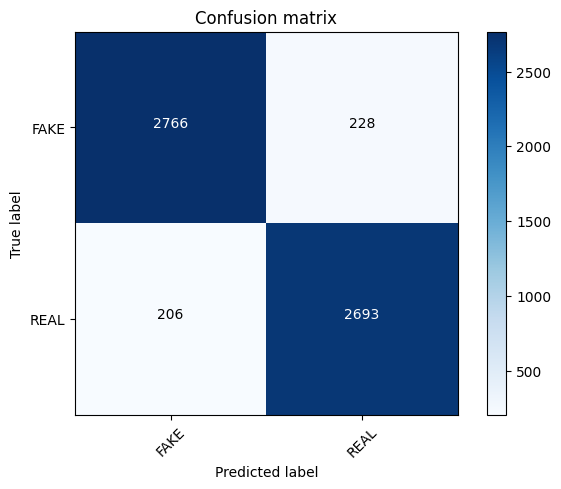

In [126]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

from sklearn import metrics
import numpy as np
import itertools

classifier.fit(XCombined, y_t)
pred = classifier.predict(VCombined)
score = metrics.accuracy_score(v_t, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(v_t, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

